In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    return mask

def augment(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
    return image, mask

def preprocess(image, mask):
    image = tf.image.resize(image, (128, 128), method="nearest")
    mask = tf.image.resize(mask, (128, 128), method="nearest")
    image = tf.cast(image, tf.float32) / 255.0
    mask = tf.cast(mask, tf.float32) / 255.0
    return image, mask

def create_dataset(image_dir, mask_dir, batch_size, image_size, augment_data=False):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir)])
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    
    def load_and_preprocess(image_path, mask_path):
        image = load_image(image_path)
        mask = load_mask(mask_path)
        image, mask = preprocess(image, mask)
        if augment_data:
            image, mask = augment(image, mask)
        return image, mask
    
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset

train_image_dir = '/path/to/the/data'
train_mask_dir = '/path/to/the/data'
test_image_dir = '/path/to/the/data'
test_mask_dir = '/path/to/the/data'

batch_size = 8
image_size = (128, 128)
augment_data = True
dataset = create_dataset(train_image_dir, train_mask_dir, batch_size, image_size, augment_data=augment_data)

dataset_size = len(os.listdir(train_image_dir))
validation_split = 0.2
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size

train_dataset = dataset.take(train_size // batch_size)
val_dataset = dataset.skip(train_size // batch_size).take(val_size // batch_size)

test_dataset = create_dataset(test_image_dir, test_mask_dir, batch_size, image_size)

# U-Net architecture
def double_conv_block(x, n_filters):
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, n_filters):
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    x = layers.Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    inputs = layers.Input(shape=(128, 128, 3))
    f1, p1 = downsample_block(inputs, 64)
    f2, p2 = downsample_block(p1, 128)
    f3, p3 = downsample_block(p2, 256)
    f4, p4 = downsample_block(p3, 512)
    bottleneck = double_conv_block(p4, 1024)
    u6 = upsample_block(bottleneck, f4, 512)
    u7 = upsample_block(u6, f3, 256)
    u8 = upsample_block(u7, f2, 128)
    u9 = upsample_block(u8, f1, 64)
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

epochs = 150

model = build_unet_model()
model.summary()
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


2024-08-02 10:03:52.287145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 10:03:52.298337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 10:03:52.310232: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 10:03:52.313870: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 10:03:52.323455: I tensorflow/core/platform/cpu_feature_guar

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 8, 8, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 8, 8, 1024)     │     9,438,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 512)    │     4,719,104 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 256)    │     1,179,904 │
│ (Conv2DTranspose)               │                        │             

 Total params: 31,379,905 (119.70 MB)

 Trainable params: 31,379,905 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150


I0000 00:00:1722614638.852725  115645 service.cc:146] XLA service 0x79cb9000e700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722614638.852757  115645 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-08-02 10:03:58.917314: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 10:04:02.381106: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-02 10:04:42.474831: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packag

   2/1055 ━━━━━━━━━━━━━━━━━━━━ 1:33 89ms/step - accuracy: 0.4715 - loss: 0.4947   

I0000 00:00:1722614683.547567  115645 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1055/1055 ━━━━━━━━━━━━━━━━━━━━ 130s 77ms/step - accuracy: 0.7107 - loss: 0.2765 - val_accuracy: 0.7158 - val_loss: 0.2718
Epoch 2/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.7169 - loss: 0.2708 - val_accuracy: 0.7126 - val_loss: 0.2748
Epoch 3/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 78s 73ms/step - accuracy: 0.7165 - loss: 0.2706 - val_accuracy: 0.7175 - val_loss: 0.2695
Epoch 4/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 64s 60ms/step - accuracy: 0.7180 - loss: 0.2700 - val_accuracy: 0.7095 - val_loss: 0.2768
Epoch 5/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.7155 - loss: 0.2720 - val_accuracy: 0.7162 - val_loss: 0.2704
Epoch 6/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.7188 - loss: 0.2685 - val_accuracy: 0.7122 - val_loss: 0.2754
Epoch 7/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 40s 38ms/step - accuracy: 0.7151 - loss: 0.2724 - val_accuracy: 0.7150 - val_loss: 0.2719
Epoch 8/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 34s 31ms/step - accuracy: 0.7145 - lo

Epoch 50/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 70s 65ms/step - accuracy: 0.7146 - loss: 0.2717 - val_accuracy: 0.7141 - val_loss: 0.2725
Epoch 51/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 74s 69ms/step - accuracy: 0.7182 - loss: 0.2697 - val_accuracy: 0.7151 - val_loss: 0.2717
Epoch 52/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 73s 68ms/step - accuracy: 0.7146 - loss: 0.2730 - val_accuracy: 0.7184 - val_loss: 0.2685
Epoch 53/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 68s 64ms/step - accuracy: 0.7150 - loss: 0.2709 - val_accuracy: 0.7131 - val_loss: 0.2745
Epoch 54/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.7136 - loss: 0.2732 - val_accuracy: 0.7182 - val_loss: 0.2689
Epoch 55/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.7172 - loss: 0.2696 - val_accuracy: 0.7184 - val_loss: 0.2701
Epoch 56/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.7132 - loss: 0.2741 - val_accuracy: 0.7183 - val_loss: 0.2687
Epoch 57/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - ac

Epoch 99/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.7128 - loss: 0.2751 - val_accuracy: 0.7189 - val_loss: 0.2680
Epoch 100/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7168 - loss: 0.2707 - val_accuracy: 0.7113 - val_loss: 0.2769
Epoch 101/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.7165 - loss: 0.2708 - val_accuracy: 0.7100 - val_loss: 0.2769
Epoch 102/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7180 - loss: 0.2695 - val_accuracy: 0.7129 - val_loss: 0.2747
Epoch 103/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7187 - loss: 0.2689 - val_accuracy: 0.7156 - val_loss: 0.2716
Epoch 104/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/step - accuracy: 0.7187 - loss: 0.2684 - val_accuracy: 0.7193 - val_loss: 0.2679
Epoch 105/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.7136 - loss: 0.2730 - val_accuracy: 0.7114 - val_loss: 0.2757
Epoch 106/150
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 45s 42ms/st

E0000 00:00:1722622252.525517  115642 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1722622252.672297  115642 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


628/628 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8442 - loss: 0.1483
Test Loss: 0.14821644127368927
Test Accuracy: 0.8443218469619751


628/628 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step


W0000 00:00:1722622260.526833  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.535586  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.535952  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.536307  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.536663  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.537046  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.537428  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.537801  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.538158  115555 gp

W0000 00:00:1722622260.929060  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.930158  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.931296  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.932533  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.933688  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.944497  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.945945  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.948140  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622260.950499  115555 gp

W0000 00:00:1722622261.339504  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.346985  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.354503  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.361998  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.369455  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.376898  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.384365  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.391887  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.399326  115555 gp

W0000 00:00:1722622261.547728  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.548206  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.548652  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.549111  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.549559  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.550020  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.550484  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.550990  115555 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1722622261.551466  115555 gp

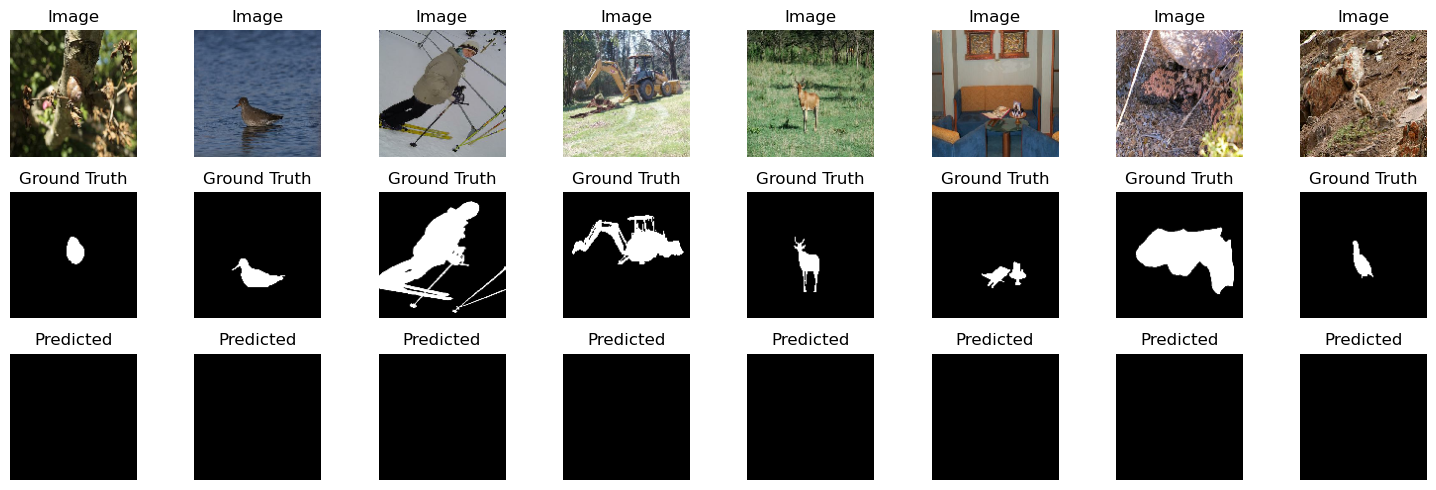

In [2]:
import matplotlib.pyplot as plt
import numpy as np

predictions = model.predict(test_dataset)

def visualize_predictions(images, masks, outputs):
    images = images.numpy() 
    masks = masks.numpy()    
    outputs = tf.sigmoid(outputs).numpy()  

    num_images = len(images)
    fig, axs = plt.subplots(3, num_images, figsize=(15, 5))

    for i in range(num_images):
        # Original Image
        axs[0, i].imshow(images[i])
        axs[0, i].set_title('Image')
        axs[0, i].axis('off')
        
        # Ground Truth Mask
        axs[1, i].imshow(masks[i, :, :, 0], cmap='gray')
        axs[1, i].set_title('Ground Truth')
        axs[1, i].axis('off')
        
        # Predicted Mask
        axs[2, i].imshow(outputs[i, :, :, 0], cmap='gray')
        axs[2, i].set_title('Predicted')
        axs[2, i].axis('off')

    plt.tight_layout()
    plt.show()

loss_fn = tf.keras.losses.MeanAbsoluteError()

tf.random.set_seed(42)

for images, masks in test_dataset.take(1): 
    outputs = model(images, training=False)  
    loss = loss_fn(masks, outputs)

    visualize_predictions(images, masks, outputs)
    break  
